# **Classifying Colon Histopathology Images Using Machine Learning**

Names: Vonny Nguyen,
Student IDs: s3992230,

### Problem Statement:
Colorectal cancer is one of the most prevalent cancers globally, and early detection is critical for improving treatment outcomes. However, manual diagnosis of colon histopathology images is labor-intensive, time-consuming, and subject to inter-observer variability. The goal of this project is to design and evaluate a machine learning system that can assist in diagnosing colon cancer by analyzing histopathology images of individual cells.

The system is designed to perform two key tasks:
- Binary classification – determine whether a given cell is cancerous or not.
- Multi-class classification – identify the cell type as fibroblast, inflammatory, epithelial, or other.

An accurate automated model would support pathologists by improving consistency, reducing diagnostic workload, and potentially accelerating decision-making in clinical workflows. Throughout the project, various preprocessing techniques and machine learning models will be explored, evaluated, and compared to select the most effective approach for both classification tasks.

### Dataset Overview: 
The dataset consists of 27x27-pixel color images of colon cells collected from 99 patients, divided into two labeled subsets:
- mainData.csv: contains full labels (cancer status and cell type) for 60 patients.
- extraData.csv: contains partial labels (cancer status only) for 39 additional patients.

Each image is an RGB image with a corresponding cancer label (isCancerous: 0 or 1) and, where available, a cell type label (cellTypeName: fibroblast, inflammatory, epithelial, other). Due to the small image size, high intra-class similarity, and significant class imbalance (e.g., far fewer cancerous images than non-cancerous), this dataset presents several challenges. These characteristics make it well-suited for experimenting with image-specific machine learning approaches, particularly convolutional neural networks (CNNs).

### Goals:
This project aims to:
- Build a reliable binary classifier for detecting cancerous cells.
- Develop a multi-class classifier to label cells by their biological type.
- Compare the performance of various machine learning models and preprocessing strategies.
- Use well-justified evaluation metrics beyond simple accuracy (e.g., recall, F1-score) to ensure meaningful results, particularly for imbalanced classes.
- Benchmark the final models against prior approaches in the literature, where possible, to assess effectiveness.

In [40]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFilter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers, models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from zipfile import ZipFile
import cv2

In [41]:
with ZipFile(r'Machine-Learning\Image_classification_data.zip', 'r') as zipobj:
    zipobj.extractall('colon_data')

In [42]:
image_dir = 'colon_data'
print(os.listdir(image_dir))

['data_labels_extraData.csv', 'data_labels_mainData.csv', 'patch_images', '__MACOSX']


In [43]:
#Loading CSV
df2 = pd.read_csv('colon_data/data_labels_mainData.csv')
df1 = pd.read_csv('colon_data/data_labels_extraData.csv')

In [44]:
df2.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [45]:
df1.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


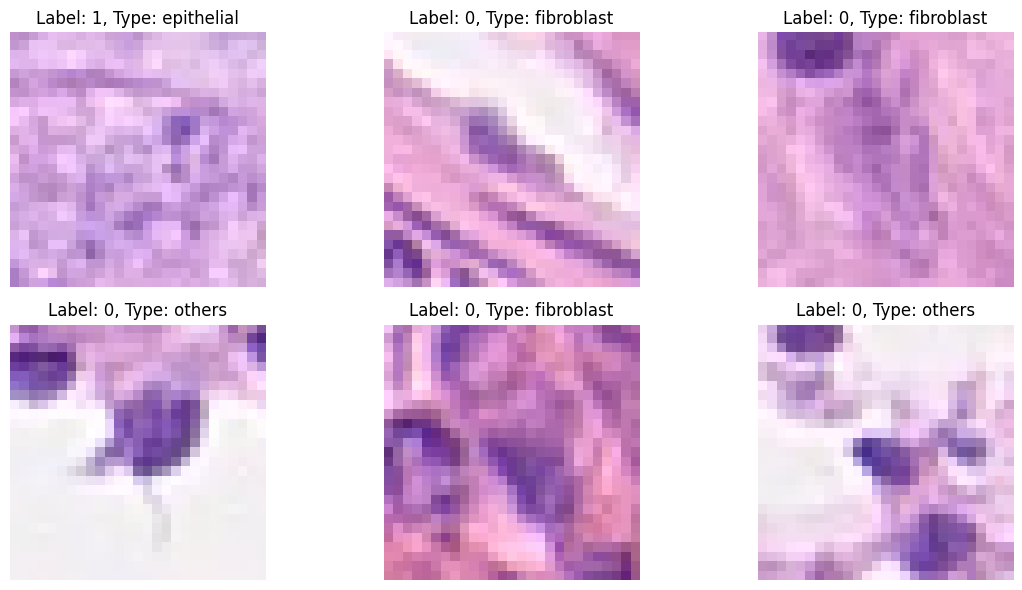

In [46]:
image_dir = 'colon_data/patch_images'

def display_sample_images(df, num_samples=6):
    sample_df = df.sample(n=num_samples)
    plt.figure(figsize=(12, 6))

    for i, (_, row) in enumerate(sample_df.iterrows()):
        img_path = os.path.join(image_dir, row['ImageName'])
        img = Image.open(img_path)
 
        # Dynamically build the title
        title = f"Label: {row['isCancerous']}"
        if 'cellTypeName' in row:
            title += f", Type: {row['cellTypeName']}"

        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Display samples from main_df(df2)
display_sample_images(df2)

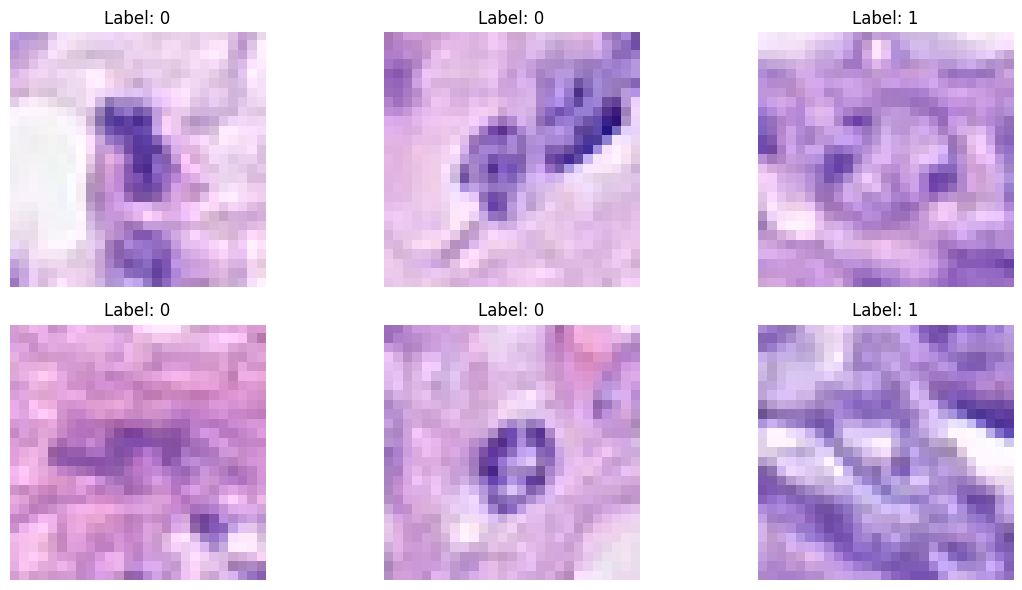

In [47]:
display_sample_images(df1)

# Exploratory Data Analysis
Exploratory data analysis (EDA) was conducted to gain insights into class distributions, image characteristics, and potential correlations, informing model selection and preprocessing decisions. The key findings are summarized below.

# Relationship Between Cell Type and Cancer Status

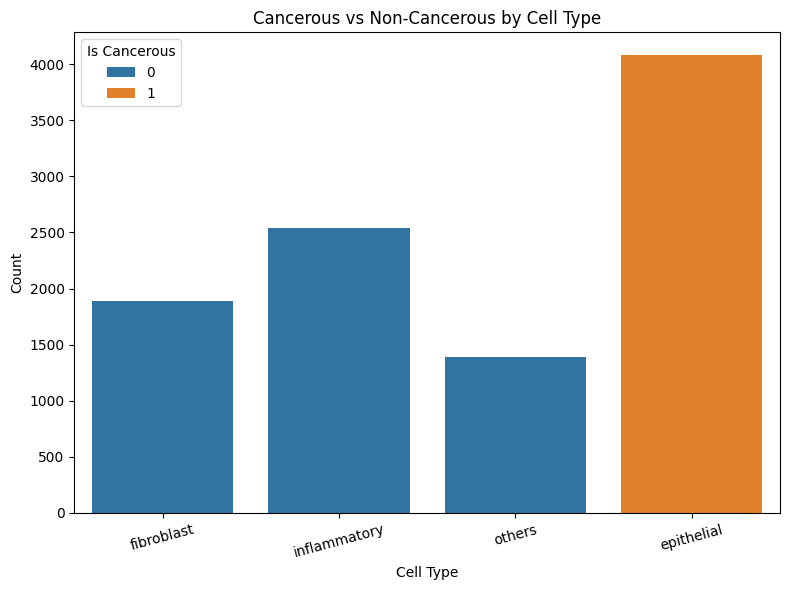

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x='cellTypeName', hue='isCancerous', data=df2)
plt.title('Cancerous vs Non-Cancerous by Cell Type')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.legend(title='Is Cancerous')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### Key Insights
A grouped bar chart was plotted to show the distribution of cancerous (isCancerous = 1) and non-cancerous (isCancerous = 0) cells across different cell types. The most notable insights include:
- Epithelial cells are almost exclusively labeled as cancerous, suggesting a strong biological link between this cell type and cancer presence.
- In contrast, fibroblast, inflammatory, and other cell types are predominantly non-cancerous.

Implication: This strong correlation between cell type and cancer label may influence the learning process of the classification models. In multi-task or joint classification models, such dependency might introduce bias or lead to feature leakage if not handled carefully.

# Distribution of Cancer labels in Main vs Extra Data

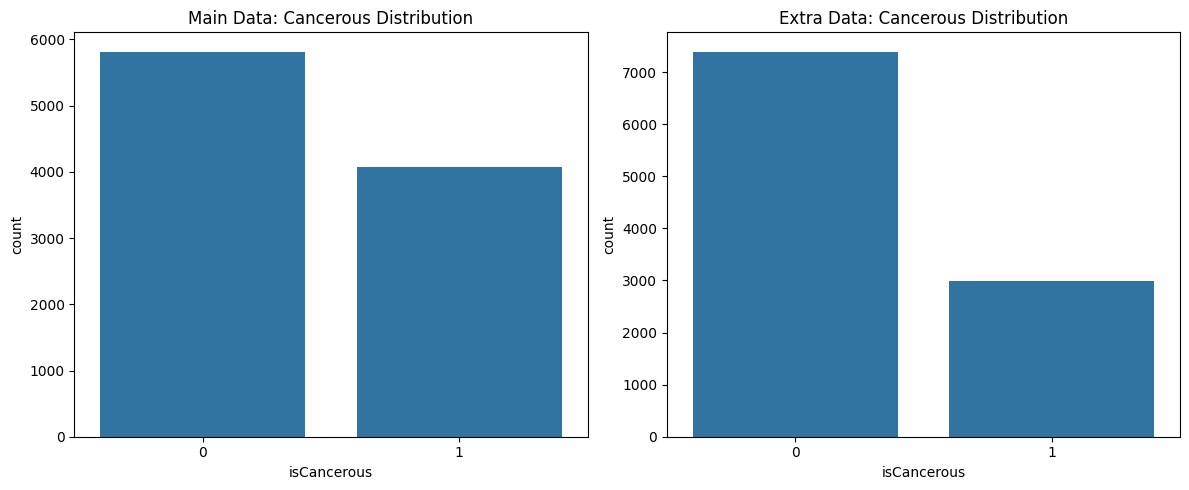

In [49]:
# Check cancerous label distribution in main and extra data
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x='isCancerous', data=df2, ax=axs[0])
axs[0].set_title('Main Data: Cancerous Distribution')

sns.countplot(x='isCancerous', data=df1, ax=axs[1])
axs[1].set_title('Extra Data: Cancerous Distribution')

plt.tight_layout()
plt.show()

### Observations
To inspect potential class imbalances, we visualized the cancer label distribution separately for both datasets:
- Main dataset: More non-cancerous samples than cancerous ones.
- Extra dataset: Shows a similar imbalance, reinforcing that cancerous cases are underrepresented overall.

Implication: The skewed label distribution may bias classifiers toward predicting the majority class (non-cancerous). In medical contexts, this is particularly dangerous as false negatives (failing to identify cancer) can have serious consequences. This necessitates the use of imbalance-handling strategies like data augmentation or class weighting during training.

# Missing Values Check

In [50]:
print("Missing values in df2:")
print(df2.isnull().sum())

print("\nMissing values in df1:")
print(df1.isnull().sum())

Missing values in df2:
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

Missing values in df1:
InstanceID     0
patientID      0
ImageName      0
isCancerous    0
dtype: int64


### Result:
We verified the presence of null or missing values in both df1 and df2:
- Result: No missing values were detected in either dataset.

Implication: Since all samples are complete, we avoid the need for imputation or sample removal, simplifying preprocessing and ensuring data integrity.

# Image Shape and Channel Analysis

100%|██████████| 9896/9896 [01:00<00:00, 164.26it/s]

        Width  Height  Channels
count  9896.0  9896.0    9896.0
mean     27.0    27.0       3.0
std       0.0     0.0       0.0
min      27.0    27.0       3.0
25%      27.0    27.0       3.0
50%      27.0    27.0       3.0
75%      27.0    27.0       3.0
max      27.0    27.0       3.0


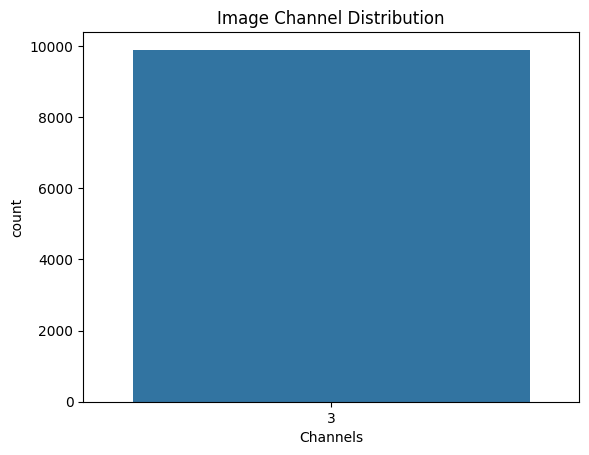

In [51]:
from tqdm import tqdm

def get_image_shapes(df):
    shapes = []
    for img_name in tqdm(df['ImageName']):
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path)
        shapes.append(img.size + (len(img.getbands()),))  # (width, height, channels)
    return shapes

shapes_main = get_image_shapes(df2)
shapes_df = pd.DataFrame(shapes_main, columns=['Width', 'Height', 'Channels'])
print(shapes_df.describe())

sns.countplot(x='Channels', data=shapes_df)
plt.title('Image Channel Distribution')
plt.show()

### Observations
Using a custom function, we extracted and analyzed the shape of every image:
- All images have consistent dimensions of 27×27 pixels and 3 color channels (RGB).
- No variation in shape or channels was observed.

Implication: This uniformity greatly simplifies image preprocessing and batching during model training, particularly for convolutional neural networks (CNNs), which expect fixed-size inputs.

# Class Distribution in Combined Dataset

### Loading Data
Since we are developing two distinct machine learning models—one for predicting cell type and another for identifying whether a cell is cancerous—we will first extract only the relevant columns which would be used for predictions (ImageName, isCancerous) from df1 and then append (concatenate) them to df2 so that we have a unified dataset to work with.

So we will make 2 dataframes (dfcancer) and another (dfcell)

In [52]:
dfcancer = pd.concat([df2[['ImageName', 'isCancerous']],df1[['ImageName', 'isCancerous']]],axis = 0)
dfcell = df2[['ImageName','cellType']]

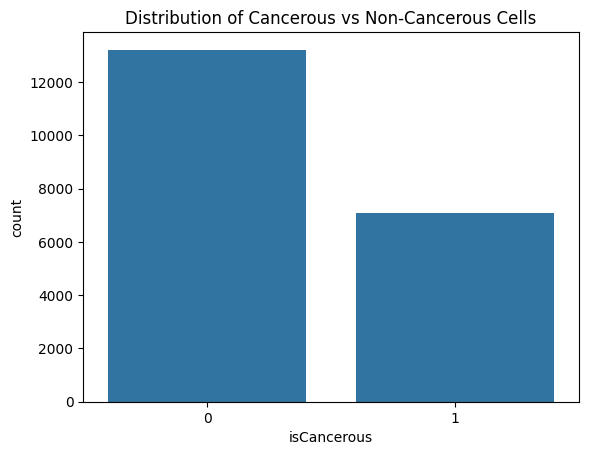

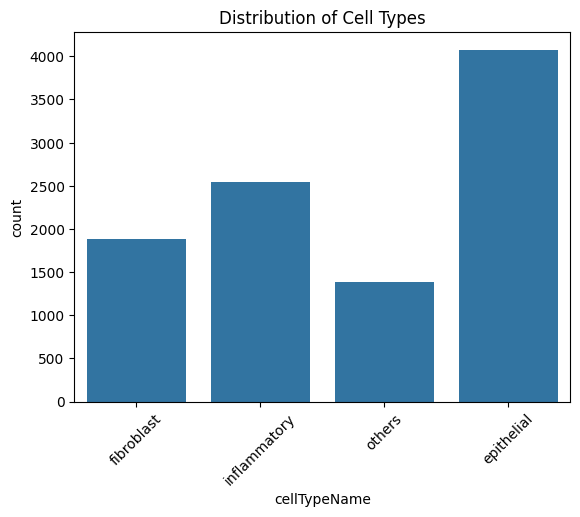

In [53]:
sns.countplot(x='isCancerous', data=dfcancer)
plt.title('Distribution of Cancerous vs Non-Cancerous Cells')
plt.show()

# cellType distribution
sns.countplot(x='cellTypeName', data=df2)
plt.title('Distribution of Cell Types')
plt.xticks(rotation=45)
plt.show()

### Observations
We further explored the overall distribution across both datasets:
1. ***isCancerous Distribution:***
- The bar chart for the isCancerous label shows a noticeable class imbalance.
- The majority of samples are non-cancerous (label 0), accounting for 13211 samples.
- In contrast, cancerous (label 1) samples total just around 7069.

**Implication**: If left unaddressed, this imbalance can cause a binary classifier to be biased toward predicting the majority class (non-cancerous), potentially leading to high accuracy but poor recall for the cancerous class — which is medically critical.

2. ***Cell Type Distribution:***
- The distribution of cellTypeName reveals a moderate class imbalance:
- The epithelial category is the most represented, with more than 4,000 instances.
- In contrast, classes such as others and fibroblast have less than 2,000 samples each.

**Implication**: In a multi-class classification task, this imbalance may lead the model to favor the dominant class (epithelial), while performing poorly on underrepresented categories. This could negatively impact metrics like the macro F1-score and reduce the model's ability to generalize across all classes.

# **Techniques we will use to Handle Class Imbalance**
We plan to apply the following techniques to mitigate the effects of imbalance:
1. Data Augmentation:
We will generate synthetic variations (e.g., rotations, shifts, flips) of minority class images to artificially balance class sizes. This is especially helpful in boosting model generalization without collecting more real-world data.

2. Class Weighting:
During model training, we will assign higher weights to underrepresented classes so that the loss function penalizes misclassification of minority samples more heavily. This improves recall and ensures minority classes receive adequate attention.

Note: These strategies will be implemented after completing the image preprocessing pipeline in the upcoming sections.

# **Data Preprocessing**

### Objective
***This section outlines the development and evaluation of a Convolutional Neural Network (CNN) to classify histopathological images of cells as cancerous or non-cancerous (binary classification), and to further identify specific cancer cell types (multi-class classification). The goal is to develop a robust, generalizable model by applying various preprocessing techniques, carefully splitting the data, and adopting consistent deep learning architecture and training strategies.

**Histopathological image classification is a challenging task due to subtle visual differences between classes, class imbalance, and noise in the imaging process. Preprocessing and model regularization techniques are thus key to improving performance. The following subsections describe the preprocessing pipeline, CNN architecture, training methodology, and evaluation techniques in detail.

### Dataset Splitting
**To train and evaluate our CNN models effectively, we split each dataset into 80% training and 20% testing subsets. This is a widely adopted convention in machine learning, providing a strong balance between having enough data to train the model and holding out sufficient data to evaluate its generalization performance.

**Stratified sampling was used to maintain the original distribution of classes within both sets, which is especially important in medical datasets where minority classes (e.g., rare cancer types) are often underrepresented.

In [54]:
traindfcancer, testdfcancer = train_test_split(
    dfcancer, test_size=0.2, random_state=42, stratify=dfcancer['isCancerous']
)
traindfcell, testdfcell = train_test_split(
    dfcell, test_size=0.2, random_state=42, stratify=dfcell['cellType']
)

### Image Preprocessing Techniques
**Before feeding the image data into the CNN, several image preprocessing techniques were explored to enhance visual features, suppress noise, and support better generalization during training. These techniques are widely used in biomedical image analysis.
- Grayscale Conversion: Converts RGB images into a single-channel grayscale format. This can reduce computational complexity and highlight texture patterns, which may be relevant in detecting malignancies.
- Gaussian Blur: Applies a Gaussian kernel to smooth the image and reduce high-frequency noise. This makes cellular boundaries more consistent and helps the model generalize better.
- Threshold Segmentation:
    - Fixed Thresholding: Applies a manually set pixel value to segment the image into foreground and background.
    - Adaptive Thresholding: Dynamically calculates thresholds based on local pixel intensities, useful in cases of non-uniform lighting.
    - Otsu’s Thresholding: Automatically determines an optimal global threshold using inter-class variance minimization.
    - Combined Preprocessing: Techniques like grayscale followed by thresholding, or blur followed by Otsu, were also tested to assess whether sequential transformations could yield improved results.

In [55]:
# Convert to grayscale
def to_grayscale(img):
    return Image.fromarray(np.uint8(img)).convert('L').convert('RGB')

# Apply Gaussian blur
def gaussian_blur(img):
    return Image.fromarray(np.uint8(img)).filter(ImageFilter.GaussianBlur(1))

# Simple fixed threshold segmentation (threshold = 128)
def simple_threshold_segmentation(img):
    grayscale = Image.fromarray(np.uint8(img)).convert('L')
    threshold = 128
    binary = grayscale.point(lambda p: 255 if p > threshold else 0)
    return binary.convert('RGB')

# Grayscale then segmentation (fixed threshold)
def grayscale_then_segmentation(img):
    gray = to_grayscale(img)
    seg = simple_threshold_segmentation(gray)
    return seg

# Blur then segmentation (fixed threshold)
def blur_then_segmentation(img):
    blurred = gaussian_blur(img)
    seg = simple_threshold_segmentation(blurred)
    return seg

#**

### Image Loading Pipeline
To prepare the images for input into the CNN model, we developed a custom image loading and preprocessing pipeline. This included resizing, applying optional transformations (such as grayscale conversion and Gaussian blur), and normalizing the pixel values.

The original images in the dataset were 27×27 pixels, which are relatively small and limited the CNN’s ability to learn meaningful patterns. To improve performance, all images were resized to 64×64 pixels. This decision was based on empirical results: models trained on 64×64 images consistently outperformed those trained on the original resolution. The increased size retains more spatial detail, allows the model to leverage deeper architectures effectively, and provides a richer signal that improves generalization.

After resizing, pixel values were normalized to the range [0, 1] by dividing by 255. Normalization helps the model train more efficiently by standardizing the input range, which stabilizes gradients and improves compatibility with layers like ReLU and batch normalization. Together, these preprocessing steps enhanced the training stability and overall performance of the CNN.

In [56]:
def load_and_preprocess_images(df, image_dir, preprocessing_fn=None):
    images = []
    for img_name in tqdm(df['ImageName']):
        try:
            img_path = os.path.join(image_dir, img_name)
            img = Image.open(img_path)
            if preprocessing_fn:
                img = preprocessing_fn(img)
            img = img.resize((64, 64))
            img = np.array(img, dtype=np.float32) / 255.0
            images.append(img)
        except Exception as e:
            print(f"Skipped {img_name}: {e}")
            continue
    return np.array(images)

# **CNN Model Development**
### Architecture
To ensure a fair comparison between preprocessing methods, a consistent Convolutional Neural Network (CNN) architecture was used throughout all experiments. The model is designed for binary classification (cancerous vs. non-cancerous) and includes two convolutional layers with ReLU activation, followed by max-pooling layers to reduce spatial dimensions. L2 regularization was applied to convolutional and dense layers to prevent overfitting, and a dropout layer with a rate of 0.6 improves generalization. The final dense layer uses a sigmoid activation function for binary output.

The model balances architectural depth and regularization, supporting meaningful feature extraction while minimizing the risk of overfitting on a relatively small histopathology dataset.

In [57]:
def create_cancer_cnn(input_shape=(27, 27, 3)):
    l2 = regularizers.l2(0.001)
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2, input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=l2),
        layers.Dropout(0.6),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

### Compilation
**The model was compiled with the Adam optimizer using a learning rate of 0.0001, which provided a good trade-off between convergence speed and stability. Binary cross-entropy was selected as the loss function, appropriate for binary classification.

In [58]:
def compile_cancer_cnn(input_shape=(64, 64, 3), lr=1e-4):
    model = create_cancer_cnn(input_shape=input_shape)
    model.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model

### Training Strategy
#### Data Augmentation
**Given the relatively small dataset, data augmentation was used to artificially expand the training set and introduce variability. This includes random rotations, shifts, and horizontal flips. This helps prevent overfitting and improves the model’s robustness to transformations.

#### Handling Class Imbalances
**In cancer datasets, there is often a class imbalance, with fewer cancerous cases than non-cancerous. To address this, class weights were computed using compute_class_weight from sklearn, allowing the model to give more importance to the minority class during training.

#### Early Stopping
**To prevent overfitting and reduce training time, early stopping was employed. If the validation loss did not improve after three consecutive epochs, training was halted, and the best weights were restored.

In [59]:
def train_model(model, Xtrain, ytrain, Xval, yval):
    augment_gen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True
    )
    val_gen = ImageDataGenerator()

    train_gen = augment_gen.flow(Xtrain, ytrain, batch_size=32, shuffle=True)
    val_gen_ = val_gen.flow(Xval, yval, batch_size=32, shuffle=False)

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    class_weights = compute_class_weight('balanced', classes=np.unique(ytrain), y=ytrain)
    class_weight_dict = dict(enumerate(class_weights))

    history = model.fit(
        train_gen,
        validation_data=val_gen_,
        epochs=15,
        class_weight=class_weight_dict,
        callbacks=[early_stop],
        verbose=1
    )

    return model, history

# **Model Evaluation**
### Evaluation Strategy
**After training, the model was evaluated on the unseen test set. Key performance metrics included:
- Accuracy
- Loss
- Precision, Recall, F1-Score (reported in Results section)

Learning curves were plotted to visualize training progress and detect signs of underfitting or overfitting.

In [60]:
def evaluate_model(model, history, Xtest, ytest, label=""):
    val_acc = history.history['val_accuracy'][-1]
    print(f"Final Validation Accuracy with {label}: {val_acc:.4f}")

    # Plot
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy - {label}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss - {label}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return val_acc

In [61]:
def evaluate_model(model, history, Xtest, ytest, label=""):
    print(f"\n=== Evaluation: {label} ===")
    ypred_probs = model.predict(Xtest)
    ypred_classes = (ypred_probs > 0.5).astype("int32")

    # Accuracy and Loss
    loss, accuracy = model.evaluate(Xtest, ytest, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(ytest, ypred_classes, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(ytest, ypred_classes)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Cancerous', 'Cancerous'],
                yticklabels=['Non-Cancerous', 'Cancerous'])
    plt.title(f'Confusion Matrix: {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # ROC-AUC Score
    try:
        auc_score = roc_auc_score(ytest, ypred_probs)
        print(f"ROC-AUC Score: {auc_score:.4f}")
        RocCurveDisplay.from_predictions(ytest, ypred_probs)
        plt.title(f"ROC Curve: {label}")
        plt.tight_layout()
        plt.show()
    except:
        print("ROC-AUC calculation failed. Possibly due to data imbalance.")
    
    # Learning Curves
    plt.figure(figsize=(10, 3.5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy Curve: {label}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss Curve: {label}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    #**

### Experiment Loop
To evaluate the impact of preprocessing, multiple different approaches were tested: no transformation (baseline), grayscale, Gaussian blur, and a combination of threshold segmentation. Each dataset variant was passed through the same CNN architecture and training routine.


--- Testing: baseline ---


100%|██████████| 4056/4056 [00:15<00:00, 264.43it/s]
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/step - accuracy: 0.6792 - loss: 0.7692 - val_accuracy: 0.8250 - val_loss: 0.4777
Epoch 2/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.8053 - loss: 0.5094 - val_accuracy: 0.8558 - val_loss: 0.4117
Epoch 3/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.8255 - loss: 0.4625 - val_accuracy: 0.8671 - val_loss: 0.3933
Epoch 4/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.8353 - loss: 0.4469 - val_accuracy: 0.8577 - val_loss: 0.4052
Epoch 5/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 60ms/step - accuracy: 0.8292 - loss: 0.4484 - val_accuracy: 0.8693 - val_loss: 0.3727
Epoch 6/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.8356 - loss: 0.4295 - val_accuracy: 0.8698 - val_loss: 0.3722
Epoch 7/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.8387 - loss: 0.4238 - val_accuracy: 0.8671 - val_loss: 0.3651
Epoch 8/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.8331 - loss: 0.4318 - 

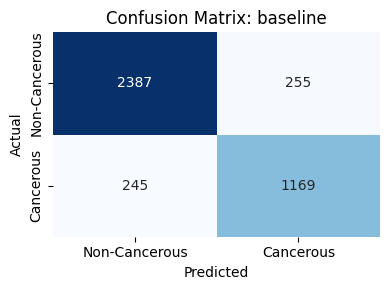

ROC-AUC Score: 0.9369


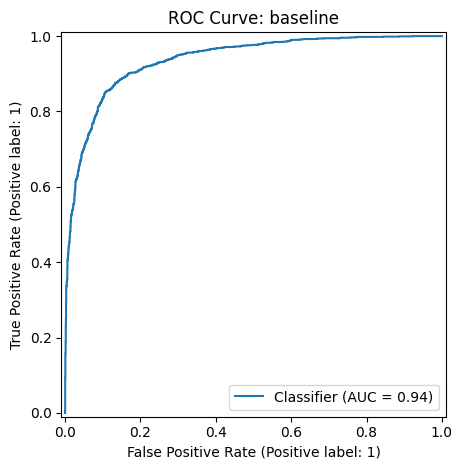

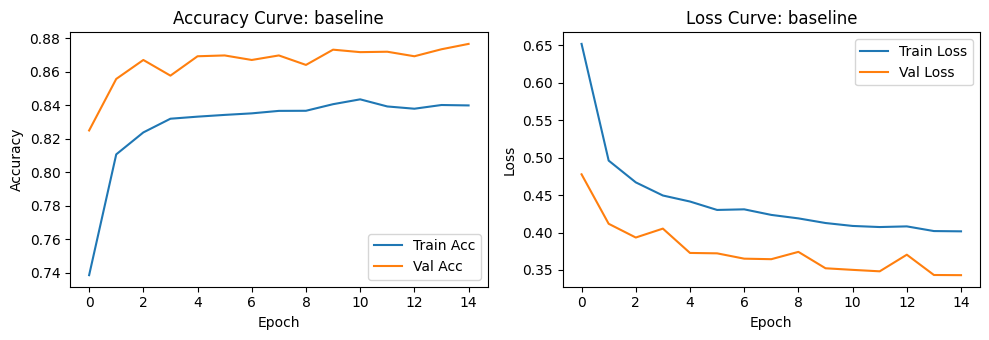


--- Testing: grayscale ---


100%|██████████| 4056/4056 [00:01<00:00, 2299.64it/s]
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/step - accuracy: 0.6040 - loss: 0.8520 - val_accuracy: 0.7747 - val_loss: 0.5690
Epoch 2/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 60ms/step - accuracy: 0.7229 - loss: 0.6333 - val_accuracy: 0.8037 - val_loss: 0.5157
Epoch 3/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.7432 - loss: 0.5893 - val_accuracy: 0.7779 - val_loss: 0.5244
Epoch 4/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 33s 66ms/step - accuracy: 0.7497 - loss: 0.5685 - val_accuracy: 0.8079 - val_loss: 0.4796
Epoch 5/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.7605 - loss: 0.5569 - val_accuracy: 0.8119 - val_loss: 0.4777
Epoch 6/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.7651 - loss: 0.5481 - val_accuracy: 0.8116 - val_loss: 0.4678
Epoch 7/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step - accuracy: 0.7652 - loss: 0.5451 - val_accuracy: 0.7766 - val_loss: 0.5148
Epoch 8/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.7606 - loss: 0.5416 - 

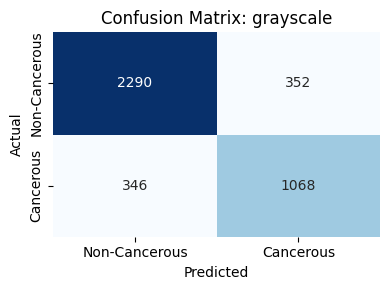

ROC-AUC Score: 0.8915


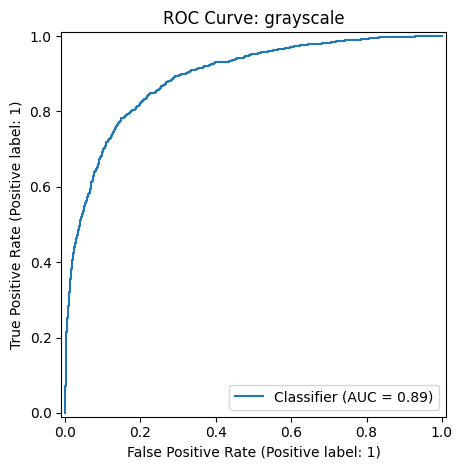

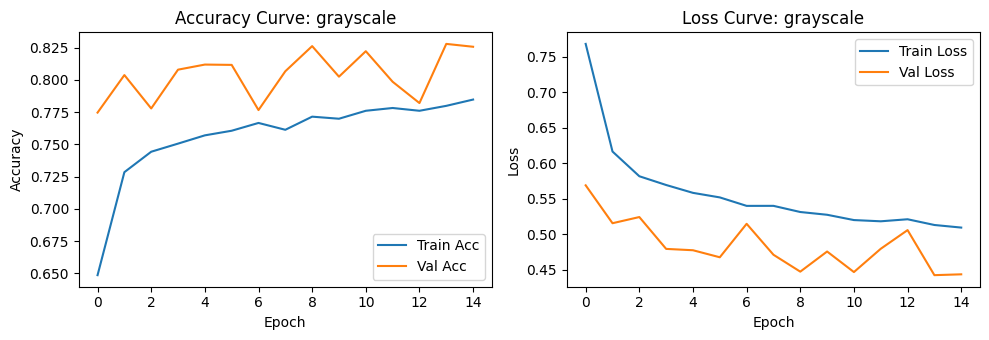


--- Testing: gaussian_blur ---


100%|██████████| 4056/4056 [00:02<00:00, 2020.58it/s]
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/step - accuracy: 0.6885 - loss: 0.7687 - val_accuracy: 0.8062 - val_loss: 0.5083
Epoch 2/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.7970 - loss: 0.5265 - val_accuracy: 0.8427 - val_loss: 0.4246
Epoch 3/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 30s 58ms/step - accuracy: 0.8036 - loss: 0.4978 - val_accuracy: 0.8476 - val_loss: 0.4147
Epoch 4/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.8184 - loss: 0.4692 - val_accuracy: 0.8491 - val_loss: 0.4084
Epoch 5/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step - accuracy: 0.8267 - loss: 0.4532 - val_accuracy: 0.8506 - val_loss: 0.4105
Epoch 6/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.8325 - loss: 0.4488 - val_accuracy: 0.8617 - val_loss: 0.3736
Epoch 7/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 29s 57ms/step - accuracy: 0.8314 - loss: 0.4329 - val_accuracy: 0.8577 - val_loss: 0.3697
Epoch 8/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.8346 - loss: 0.4279 - 

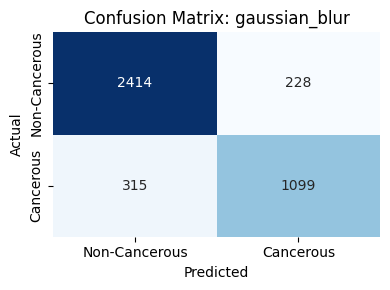

ROC-AUC Score: 0.9329


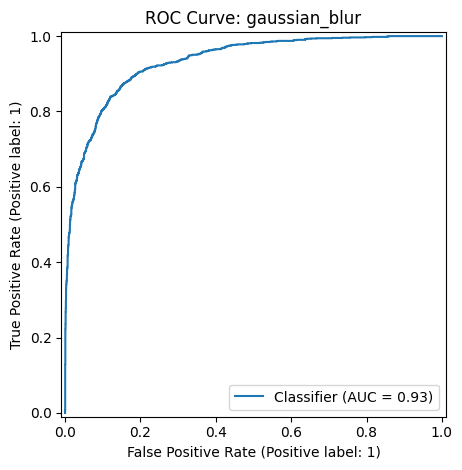

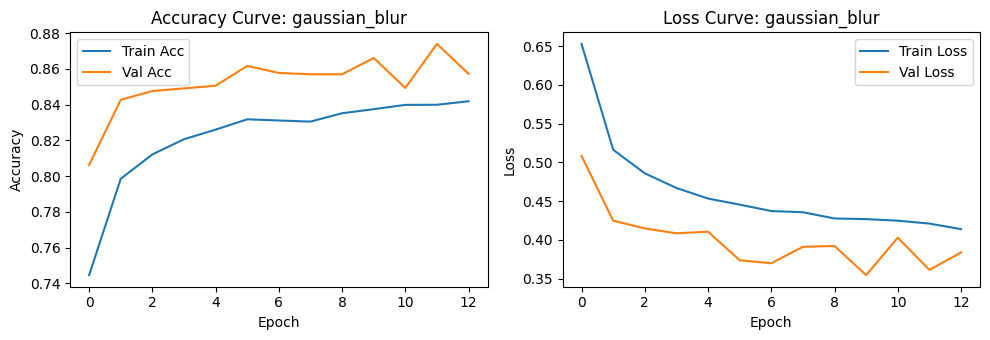


--- Testing: segmentation (fixed threshold) ---


100%|██████████| 4056/4056 [00:02<00:00, 1450.22it/s]
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.6286 - loss: 0.8505 - val_accuracy: 0.7714 - val_loss: 0.6104
Epoch 2/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.7399 - loss: 0.6504 - val_accuracy: 0.7685 - val_loss: 0.5816
Epoch 3/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.7409 - loss: 0.6206 - val_accuracy: 0.7835 - val_loss: 0.5386
Epoch 4/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - accuracy: 0.7527 - loss: 0.5929 - val_accuracy: 0.7761 - val_loss: 0.5431
Epoch 5/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 33s 64ms/step - accuracy: 0.7477 - loss: 0.5865 - val_accuracy: 0.7936 - val_loss: 0.5069
Epoch 6/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 33s 66ms/step - accuracy: 0.7651 - loss: 0.5624 - val_accuracy: 0.7712 - val_loss: 0.5328
Epoch 7/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - accuracy: 0.7567 - loss: 0.5642 - val_accuracy: 0.7821 - val_loss: 0.5101
Epoch 8/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - accuracy: 0.7578 - loss: 0.5532 - 

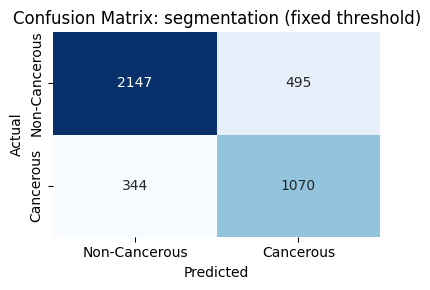

ROC-AUC Score: 0.8673


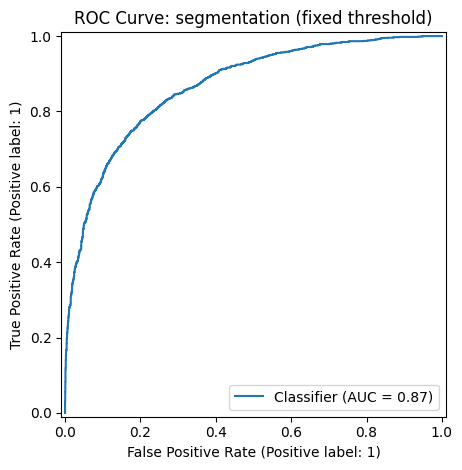

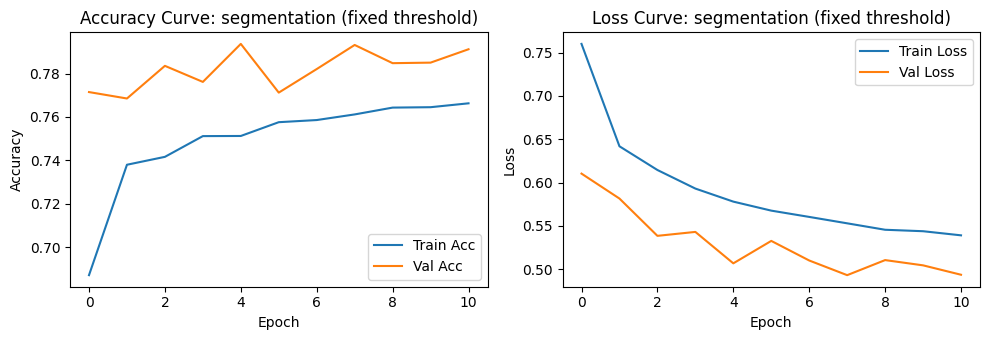


--- Testing: grayscale + segmentation ---


100%|██████████| 4056/4056 [00:02<00:00, 1623.33it/s]
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 34s 64ms/step - accuracy: 0.6478 - loss: 0.8303 - val_accuracy: 0.7584 - val_loss: 0.6223
Epoch 2/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 62ms/step - accuracy: 0.7361 - loss: 0.6572 - val_accuracy: 0.7825 - val_loss: 0.5666
Epoch 3/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.7447 - loss: 0.6167 - val_accuracy: 0.7813 - val_loss: 0.5592
Epoch 4/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.7467 - loss: 0.6091 - val_accuracy: 0.7756 - val_loss: 0.5489
Epoch 5/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - accuracy: 0.7557 - loss: 0.5854 - val_accuracy: 0.7564 - val_loss: 0.5655
Epoch 6/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.7475 - loss: 0.5828 - val_accuracy: 0.7754 - val_loss: 0.5325
Epoch 7/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.7545 - loss: 0.5728 - val_accuracy: 0.7872 - val_loss: 0.5031
Epoch 8/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.7549 - loss: 0.5678 - 

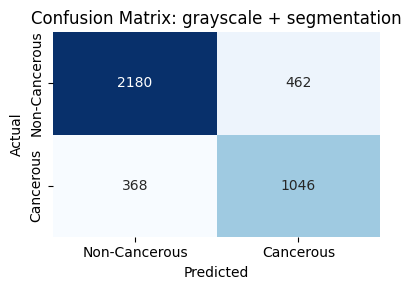

ROC-AUC Score: 0.8693


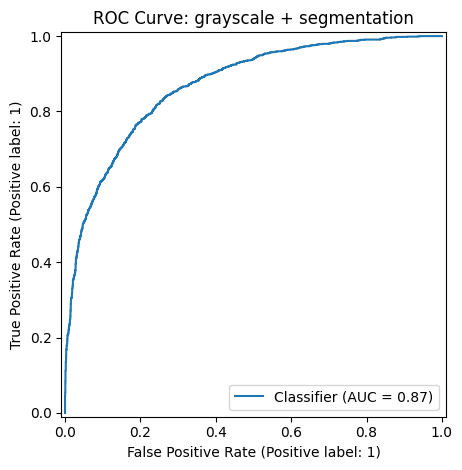

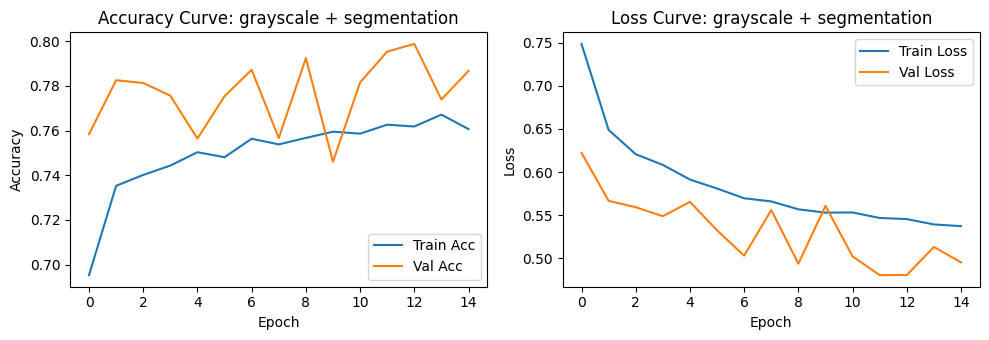


--- Testing: blur + segmentation ---


100%|██████████| 4056/4056 [00:02<00:00, 1488.37it/s]
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Vonny\Desktop\UNI\2025\Machine Learning\Machine-Learning-cross-check\Machine-Learning-cross-check\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/step - accuracy: 0.6148 - loss: 0.8549 - val_accuracy: 0.7069 - val_loss: 0.6569
Epoch 2/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.6954 - loss: 0.6952 - val_accuracy: 0.7249 - val_loss: 0.6125
Epoch 3/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.7050 - loss: 0.6647 - val_accuracy: 0.7586 - val_loss: 0.5862
Epoch 4/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.7127 - loss: 0.6466 - val_accuracy: 0.7411 - val_loss: 0.5947
Epoch 5/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.7101 - loss: 0.6286 - val_accuracy: 0.7517 - val_loss: 0.5816
Epoch 6/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0.7200 - loss: 0.6199 - val_accuracy: 0.7611 - val_loss: 0.5619
Epoch 7/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.7232 - loss: 0.6099 - val_accuracy: 0.7719 - val_loss: 0.5400
Epoch 8/15
507/507 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.7235 - loss: 0.6083 - 

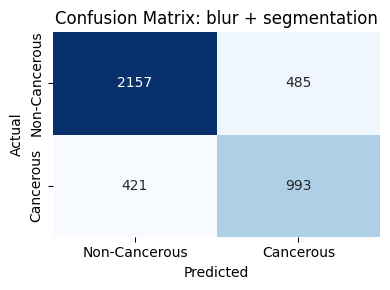

ROC-AUC Score: 0.8359


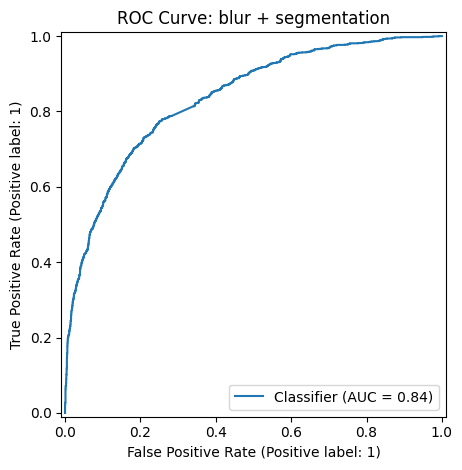

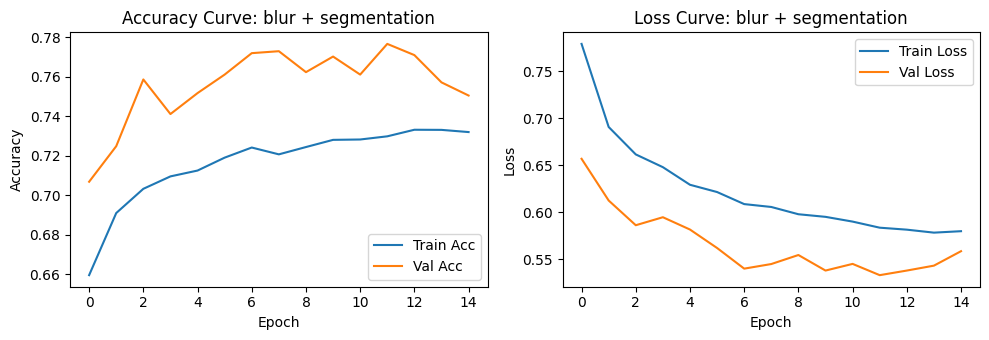


Comparison Results:


TypeError: unsupported format string passed to NoneType.__format__

In [ ]:
results = {}
histories = {}

preprocessing_methods = {
    'baseline': None,
    'grayscale': to_grayscale,
    'gaussian_blur': gaussian_blur,
    'segmentation (fixed threshold)': simple_threshold_segmentation,
    'grayscale + segmentation': grayscale_then_segmentation,
    'blur + segmentation': blur_then_segmentation,
}

for label, preprocessing_fn in preprocessing_methods.items():
    print(f"\n--- Testing: {label} ---")

    # Load and preprocess images
    Xtrain = load_and_preprocess_images(traindfcancer, image_dir, preprocessing_fn)
    Xtest = load_and_preprocess_images(testdfcancer, image_dir, preprocessing_fn)
    ytrain = traindfcancer['isCancerous'].values
    ytest = testdfcancer['isCancerous'].values

    # Create and compile model
    model = compile_cancer_cnn()

    # Train model
    model, history = train_model(model, Xtrain, ytrain, Xtest, ytest)

    # Evaluate model
    val_acc = evaluate_model(model, history, Xtest, ytest, label=label)

    # Store results
    results[label] = val_acc
    histories[label] = history
#**

In [ ]:
import seaborn as sns
import pandas as pd

result_df = pd.DataFrame(list(results.items()), columns=['Preprocessing Method', 'Validation Accuracy'])
result_df = result_df.sort_values('Validation Accuracy', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Validation Accuracy', y='Preprocessing Method', data=result_df, palette='viridis')
plt.title("CNN Validation Accuracy by Preprocessing Method")
plt.show()

#### Performance Evaluation

**To determine the most effective preprocessing method for our final model, we evaluated six different image preprocessing pipelines using multiple performance metrics: Accuracy, F1 Score (Macro Average), and ROC-AUC Score

| Preprocessing Method         | Accuracy | F1 (Macro) | ROC-AUC |
|-----------------------------|----------|------------|---------|
| **Baseline**                | 0.8767   | 0.8645     | 0.9369  |
| **Grayscale**               | 0.8279   | 0.8107     | 0.8915  |
| **Gaussian Blur**           | 0.8661   | 0.8504     | 0.9329  |
| **Segmentation**            | 0.7931   | 0.7775     | 0.8673  |
| **Grayscale + Segmentation**| 0.7954   | 0.7780     | 0.8693  |
| **Blur + Segmentation**     | 0.7766   | 0.7566     | 0.8359  |

From the results, the baseline model (with no preprocessing) achieved the highest accuracy (0.8767), macro F1 score (0.8645), and ROC-AUC (0.9369). This suggests that the original images already contain highly informative visual features suitable for classification, and aggressive preprocessing may lead to information loss.

The Gaussian blur method showed slightly lower performance than the baseline (accuracy: 0.8661, ROC-AUC: 0.9329), but consistently performed better than other preprocessing techniques. Notably, over multiple runs, Gaussian blur occasionally outperformed the baseline in terms of ROC-AUC, although the differences were marginal. This implies that slight noise reduction can enhance robustness without sacrificing crucial image features.

In contrast, grayscale conversion and segmentation, whether applied alone or in combination, consistently resulted in lower scores across all evaluation metrics. These methods potentially removed or distorted color and edge information that was relevant for classification. The blur + segmentation combination performed the worst (accuracy: 0.7766, F1: 0.7566, ROC-AUC: 0.8359), indicating compounded information loss.

Given this analysis, we selected Gaussian blur as the preferred preprocessing method for our final model. It offers a slight regularization benefit while retaining important image features and generalization ability, as evidenced by its competitive ROC-AUC and F1 scores.

## Model For multi-class cell type classification

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_gen = ImageDataGenerator()

from tensorflow.keras.utils import to_categorical

# One-hot encode labels
ycelltrain_cat = to_categorical(ycelltrain, num_classes=4)
ycelltest_cat = to_categorical(ycelltest, num_classes=4)

# Now generate flows
train_flow = train_gen.flow(Xcelltrain, ycelltrain_cat, batch_size=32, shuffle=True)
val_flow = val_gen.flow(Xcelltest, ycelltest_cat, batch_size=32, shuffle=False)

In [ ]:
from tensorflow.keras import layers, models, regularizers

def create_celltype_cnn(input_shape=(27, 27, 3), num_classes=4):
    l2 = regularizers.l2(0.001)

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2, input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Multi-class

    return model

model2 = create_celltype_cnn()

In [ ]:
from tensorflow.keras.optimizers import Adam

model2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history2 = model2.fit(
    train_flow,
    validation_data=val_flow,
    epochs=30,
    callbacks=[early_stop]
)

In [ ]:
# Get model predictions
y_pred_probs = model2.predict(Xcelltest)
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(ycelltest_cat, axis=1)  # True labels

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['fibroblast', 'inflammatory', 'epithelial', 'others'],
            yticklabels=['fibroblast', 'inflammatory', 'epithelial', 'others'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Cell Type Prediction')
plt.tight_layout()
plt.show()

In [ ]:
# Print classification report
print("Classification Report:\n")
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=['fibroblast', 'inflammatory', 'epithelial', 'others']
))


⚠️ Key Observations
Class "others" is frequently misclassified, especially as inflammatory and fibroblast.

Confusion matrix shows heavy misclassification of "others" as inflammatory — suggests they share similar features in images.

Macro F1-score is 0.60, pulled down by the poor performance on the "others" class.